# In this example, we will learn training from scratch.

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
##First build a smaller dataset
from_dir="train/"
to_dir="small_train/"
all_files=os.listdir(from_dir)
cat_files=[f for f in all_files if f[:3]=="cat"]
dog_files=[f for f in all_files if f[:3]=="dog"]

np.random.shuffle(cat_files)
np.random.shuffle(dog_files)

def mkdir_(dir_):
    if not os.path.exists(dir_):
        os.makedirs(dir_)    
train_cats=cat_files[:1000];mkdir_(os.path.join(to_dir,"train","cats"))
train_dogs=dog_files[:1000];mkdir_(os.path.join(to_dir,"train","dogs"))
val_cats=cat_files[1000:1500];mkdir_(os.path.join(to_dir,"val","cats"))
val_dogs=dog_files[1000:1500];mkdir_(os.path.join(to_dir,"val","dogs"))
test_cats=cat_files[1500:2000];mkdir_(os.path.join(to_dir,"test","cats"))
test_dogs=dog_files[1500:2000];mkdir_(os.path.join(to_dir,"test","dogs"))

def copy(choosen_cats,choosen_dogs,k):
    for c,d in tqdm(zip(choosen_cats,choosen_dogs)):
        shutil.copy(os.path.join(from_dir,c),os.path.join(to_dir,k,"cats",c))
        shutil.copy(os.path.join(from_dir,d),os.path.join(to_dir,k,"dogs",d))
        if not os.path.exists(os.path.join(to_dir,k,"cats",c)):
            print(c+"Copy Failed!")
        if not os.path.exists(os.path.join(to_dir,k,"dogs",d)):
            print(d+"Copy Failed!")
copy(train_cats,train_dogs,"train")
copy(val_cats,val_dogs,"val")
copy(test_cats,test_dogs,"test")

1000it [00:05, 195.23it/s]
500it [00:02, 180.19it/s]
500it [00:02, 188.14it/s]


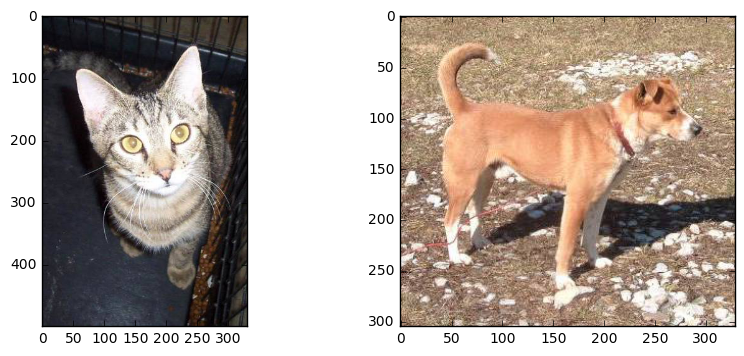

In [26]:
%matplotlib inline
from PIL import Image
fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(Image.open(os.path.join(to_dir,"train","cats",train_cats[0])))
fig.add_subplot(122)
plt.imshow(Image.open(os.path.join(to_dir,"train","dogs",train_dogs[0])))
plt.show()

train_dir=os.path.join(to_dir,"train")
val_dir=os.path.join(to_dir,"val")
test_dir=os.path.join(to_dir,"test")

# Next,we need to do the preprocessing.
 First, read from directory and transform into array.
 Second, divede by 255.
 Third, resize them.
## Thankfully, Keras has function to do these for us.

In [27]:
from keras.preprocessing.image import ImageDataGenerator
##Rescale by 1./255
train_gen=ImageDataGenerator(rescale=1./255)
test_gen=ImageDataGenerator(rescale=1./255)
##Generate data from directory
train_gener=train_gen.flow_from_directory(
            train_dir,#assign the training dir
            target_size=(150,150),
            batch_size=20,
            class_mode="binary"
            )


Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
